In [1]:
#!pip install yfinance mplfinance matplotlib

In [16]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
# for Japanese Candles analysis
import matplotlib.dates as mdates
# for Elliot Wave analysis
from scipy.signal import find_peaks

In [17]:
def download_stock_data(symbol, start, end):
    """
    Download stock data from yfinance.
    """
    data = yf.download(symbol, start=start, end=end)
    return data

def calculate_ema(data, period, column='Close'):
    """
    Calculate Exponential Moving Average (EMA) for a given period.
    """
    return data[column].ewm(span=period, adjust=False).mean()

def identify_support_levels(data, window=20):
    """
    Identify potential support levels based on recent lows within a specified window.
    """
    # Find the minimum close price within the specified window
    recent_lows = data['Close'].rolling(window=window).min()
    support_levels = recent_lows[-window:].dropna().unique()  # Get unique recent low prices as support levels
    return support_levels
# candles analysis
def candle_ema_analysis(data, short_period_1=144, short_period_2=169, long_period=576):
    """
    Calculate the exponential moving averages (EMAs) for the Vegas channel analysis.
    """
    data['EMA_144'] = calculate_ema(data, 144)
    #data['EMA_144'] = data['Close'].ewm(span=short_period_1, adjust=False).mean()
    data['EMA_169'] = calculate_ema(data, 169)
    #data['EMA_169'] = data['Close'].ewm(span=short_period_2, adjust=False).mean()
    data['EMA_576'] = calculate_ema(data, 576)
    #data['EMA_576'] = data['Close'].ewm(span=long_period, adjust=False).mean()
    return data
# MCA vegas analysis
def vegas_channel_analysis(data):
    """
    Perform Vegas Channel Analysis by calculating the necessary EMAs.
    """
    # Calculate EMAs for the Vegas Tunnel (144 and 169 periods)
    data['EMA_144'] = calculate_ema(data, 144)
    data['EMA_169'] = calculate_ema(data, 169)
    
    # Calculate shorter-term EMAs (12 and 24 periods)
    data['EMA_12'] = calculate_ema(data, 12)
    data['EMA_24'] = calculate_ema(data, 24)
    
    return data
# for Japanese Candles
#def identify_support_levels(data, window=20):
#    """
#    Identify potential support levels based on recent lows within a specified window.
#    """
#    recent_lows = data['Close'].rolling(window=window).min()
#    support_levels = recent_lows[-window:].dropna().unique()
#    return support_levels
# for elliot waves analysis
def identify_peaks_and_troughs(prices, distance=5):
    """
    Identify local peaks and troughs in price data.
    
    Parameters:
    - prices (pd.Series): The price data to analyze (e.g., close prices).
    - distance (int): Minimum number of points between peaks or troughs.
    
    Returns:
    - peaks (list): Indices of local maxima.
    - troughs (list): Indices of local minima.
    """
    # Find peaks (local maxima)
    peaks, _ = find_peaks(prices, distance=distance)
    
    # Find troughs (local minima)
    troughs, _ = find_peaks(-prices, distance=distance)
    
    return peaks, troughs

In [4]:
def plot_vegas_channel(data, symbol, buy_date=None, buy_price=None):
    """
    Plot the stock's closing prices along with the Vegas Tunnel (144 and 169 EMAs), shorter-term EMAs and highlight the buying price on the given date.
        Parameters:
    - data (pd.DataFrame): Stock data containing 'Close', 'Volume', and EMAs.
    - symbol (str): Stock ticker symbol.
    - buy_date (str): Date of the buying price (format 'YYYY-MM-DD').
    - buy_price (float): Buying price on the given date.
    """
    # Info about stock
    stock = yf.Ticker(symbol)
    info = stock.info
    try:
        sector = info['sector'] or "Undef"
    except KeyError:
        sector = "ETF"
    latest_close = data['Close'].iloc[-1]
    latest_date = data.index[-1]
    # compute trend
    trend = None
    if buy_price :
        d_trend = latest_close - buy_price # hope is positive
        per_trend = (d_trend / buy_price) * 100
        trend = f" {per_trend:.2f}% "
    # Identify support levels
    support_levels = identify_support_levels(data)
    
    # create subplots so I can see volume of stocks
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10), sharex=True, gridspec_kw={'height_ratios': [3,1]})
    
    # Plot the closing prices
    ax1.plot(data['Close'], label='Close Price', color='blue', alpha=0.5)
    
    # Plot the Vegas Tunnel (EMA 144 and EMA 169)
    ax1.plot(data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    ax1.plot(data['EMA_169'], label='EMA 169', color='red', linestyle='--')
    
    # Plot the shorter-term EMAs (EMA 12 and EMA 24)
    ax1.plot(data['EMA_12'], label='EMA 12', color='purple')
    ax1.plot(data['EMA_24'], label='EMA 24', color='orange')

    
    # Highlight the buying price
    if buy_date and buy_price:
        buy_date_parsed = pd.to_datetime(buy_date)
        if buy_date_parsed in data.index:
            ax1.scatter(buy_date_parsed, buy_price, color='red', s=100, zorder=5, label=f"My Price: {buy_price:.2f} {trend}")
            ax1.annotate(f"My Price: {buy_price:.2f} {trend}", xy=(buy_date_parsed, buy_price),
                         xytext=(buy_date_parsed, buy_price * 1.05),
                         arrowprops=dict(facecolor='red', shrink=0.05),
                         fontsize=10, color='red')

    # Hightlight latest close price
    ax1.scatter(latest_date, latest_close, color='black', zorder=5, label=f"Latests Close: {latest_close:.2f}")
    ax1.axhline(latest_close, color='black', linestyle=':', alpha=0.7)
    
    # Plot support levels
    for level in support_levels:
        ax1.axhline(level, color='purple', linestyle='--', alpha=0.5, label=f'Support Level: {level:.2f}')

    # Customize the plot
    ax1.set_title(f'{latest_date}-Vegas Channel Analysis for {symbol}-{sector}')
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax1.grid(True)
    
    # Plot volume on ax2
    ax2.bar(data.index, data['Volume'], fill='lightblue', color='red', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True)
    
    # adjust layout
    plt.tight_layout()
    plt.show()

In [18]:
def plot_candlestick_with_vegas_and_support(data, symbol):
    """
    Plot candlesticks, Vegas channels, support levels, and volume.
    """
    # Prepare figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    # Convert date index to numeric x-coordinates for consistent plotting
    data['Date_num'] = mdates.date2num(data.index)  # Convert datetime index to numeric
    x_coords = data['Date_num']
    # Format date for x-axis
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()


    # Plot candlesticks
    for i in range(len(data)):
        open_price = data['Open'][i]
        close_price = data['Close'][i]
        high_price = data['High'][i]
        low_price = data['Low'][i]
        
        # Color settings for up (green) and down (red) candles
        color = 'green' if close_price >= open_price else 'red'
        
        # Draw the candle's body
        #ax1.add_patch(plt.Rectangle((i - 0.2, min(open_price, close_price)),
        #                            0.4, abs(close_price - open_price),
        #                            color=color, alpha=0.6))
        ax1.add_patch(plt.Rectangle((x_coords[i] - 0.2, min(open_price, close_price)),0.4, abs(close_price - open_price),color=color, alpha=0.6))
        
        # Draw the candle's wick
        #ax1.plot([i, i], [low_price, high_price], color=color, linewidth=0.8)
        ax1.plot([x_coords[i], x_coords[i]], [low_price, high_price], color=color, linewidth=0.8)

    # Plot the Vegas channels
    ax1.plot(data.index, data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    ax1.plot(data.index, data['EMA_169'], label='EMA 169', color='orange', linestyle='--')
    ax1.plot(data.index, data['EMA_576'], label='EMA 576', color='red', linestyle='--')

    # Highlight latest close price
    latest_close = data['Close'].iloc[-1]
    latest_date = data.index[-1]
    ax1.scatter(latest_date, latest_close, color='black', zorder=5, label=f'Latest Close: {latest_close:.2f}')
    ax1.axhline(latest_close, color='black', linestyle=':', alpha=0.7)

    # Plot support levels
#    support_levels = identify_support_levels(data)
#    for level in support_levels:
#        ax1.axhline(level, color='purple', linestyle='--', alpha=0.5, label=f'Support Level: {level:.2f}')

    # Labels and legend for ax1 (price chart)
    ax1.set_title(f"Candlestick Chart with Vegas Channels and Support Levels for {symbol}")
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax1.grid(True)

    # Plot volume on ax2
    ax2.bar(data.index, data['Volume'], color='gray', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [19]:
def plot_elliott_wave(prices, peaks, troughs, title="Elliott Wave Analysis"):
    """
    Plot the price data with detected Elliott wave points (peaks and troughs).
    
    Parameters:
    - prices (pd.Series): The price data to plot.
    - peaks (list): Indices of local maxima.
    - troughs (list): Indices of local minima.
    - title (str): Title of the chart.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(prices, label='Stock Price', color='blue', alpha=0.7)
    
    # Highlight peaks and troughs
    #plt.scatter(peaks, prices[peaks], color='green', label='Peaks (Wave Highs)', marker='o')
    #plt.scatter(troughs, prices[troughs], color='red', label='Troughs (Wave Lows)', marker='o')
    
    plt.scatter(prices.index[peaks], prices.iloc[peaks], color='green', label='Peaks (Wave Highs)', marker='o')
    plt.scatter(prices.index[troughs], prices.iloc[troughs], color='red', label='Troughs (Wave Lows)', marker='o')
    
    # Connect wave points
    wave_points = sorted(list(peaks) + list(troughs))
    #plt.plot(wave_points, prices[wave_points], color='orange', linestyle='--', label='Elliott Wave')
    plt.plot(prices.index[wave_points], prices.iloc[wave_points], color='orange', linestyle='--', label='Elliott Wave')
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

In [21]:
# Stock symbol and date range
symbol = 'TSLA'  # Tesla
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-12-26', 439.59)
plt.close()

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TSLA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TSLA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TSLA&crumb=Edge%3A+Too+Many+Requests


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TSLA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


IndexError: single positional indexer is out-of-bounds

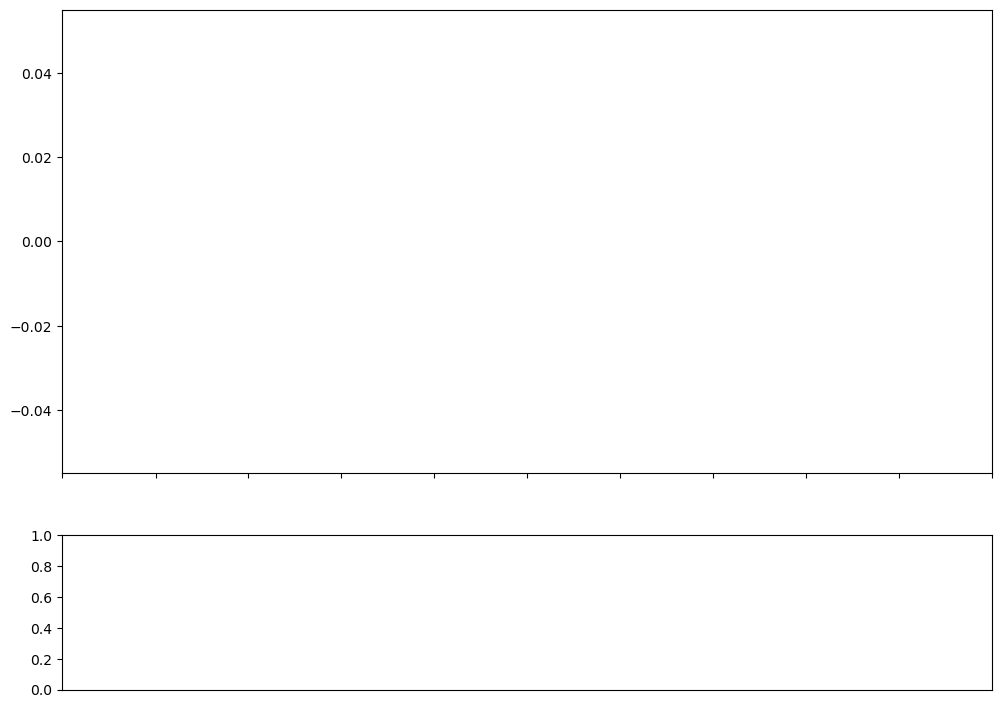

In [8]:
# Stock symbol and date range with Japanese Candles analysis
symbol = 'TSLA'  # TESLA
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 5
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-11-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)
#stock_data
# Perform Japanese Candle Analysis (calculate EMAs)
stock_data = candle_ema_analysis(stock_data)

# Plot the result
plot_candlestick_with_vegas_and_support(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TSLA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


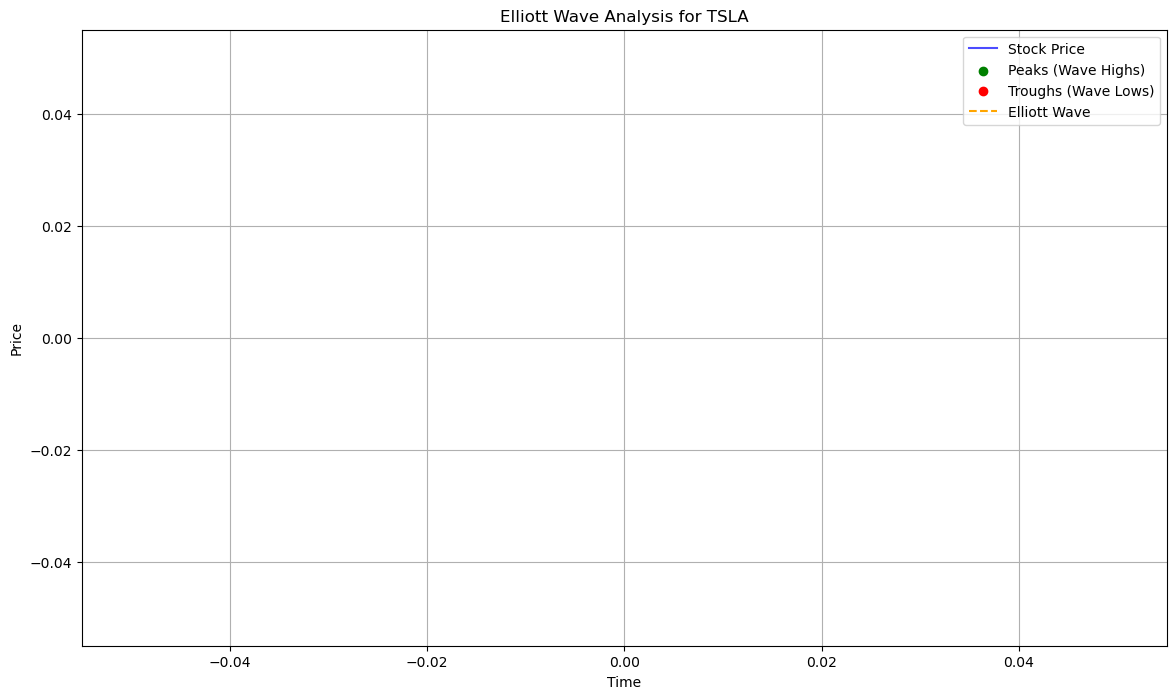

In [9]:
# Stock symbol and date range with Elliot Wave analysis
symbol = 'TSLA'  # TESLA
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 6
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-11-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Step 1: Download the stock data
elliot_stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Step 2: Identify peaks and troughs
elliot_close_prices = elliot_stock_data['Close']
# test
#elliot_close_prices.plot()

distance = 5
peaks, troughs = identify_peaks_and_troughs(elliot_close_prices, distance=distance)

# Step 3: Plot the Elliott wave analysis
plot_elliott_wave(elliot_close_prices, peaks, troughs, title=f"Elliott Wave Analysis for {symbol}")
plt.close()

In [10]:
# Stock symbol and date range
symbol = 'BTC'  # Bitcoin
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BTC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BTC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BTC&crumb=Edge%3A+Too+Many+Requests


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

[*********************100%%**********************]  1 of 1 completed


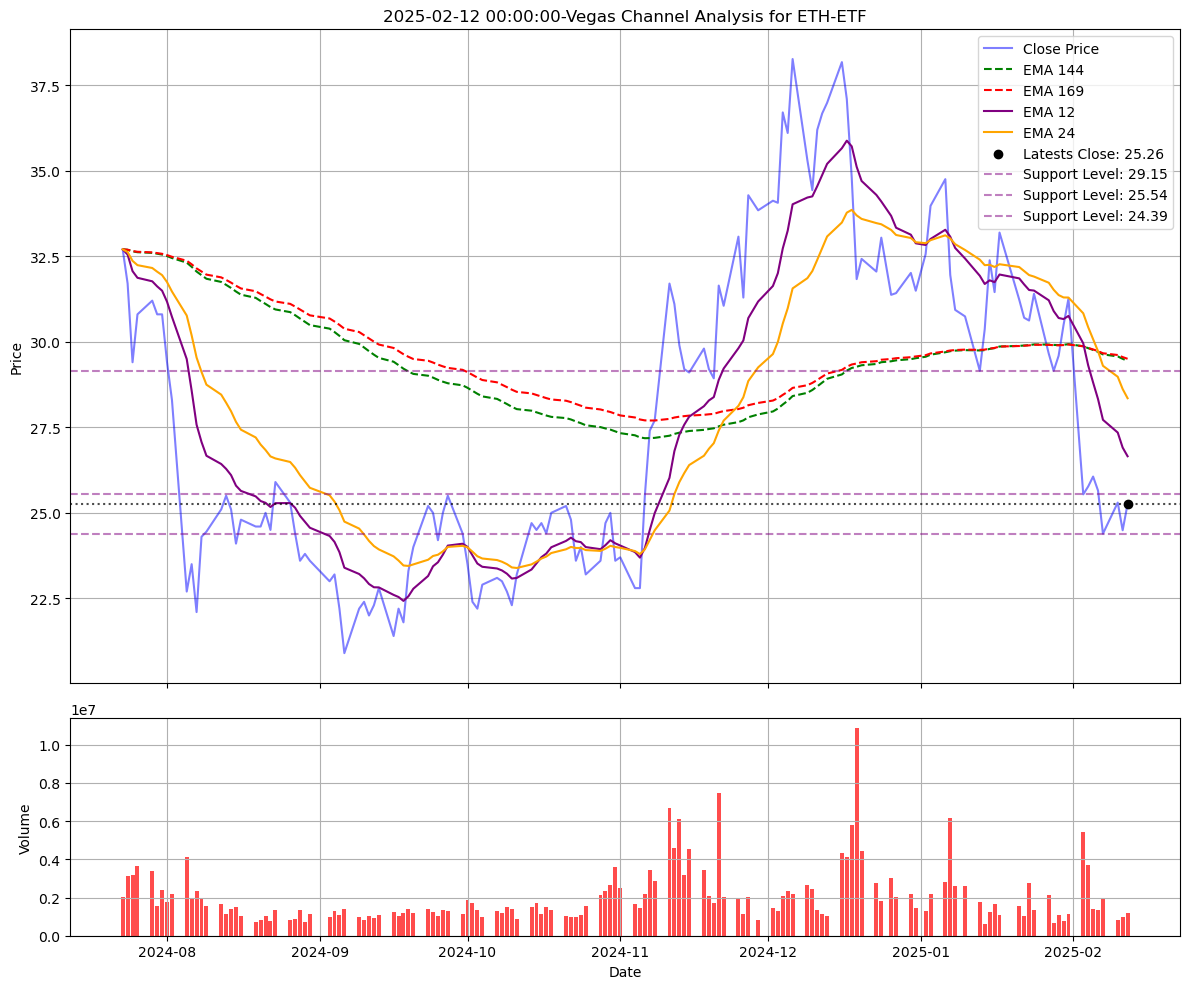

In [11]:
# Stock symbol and date range
symbol = 'ETH'  # Ethereum
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


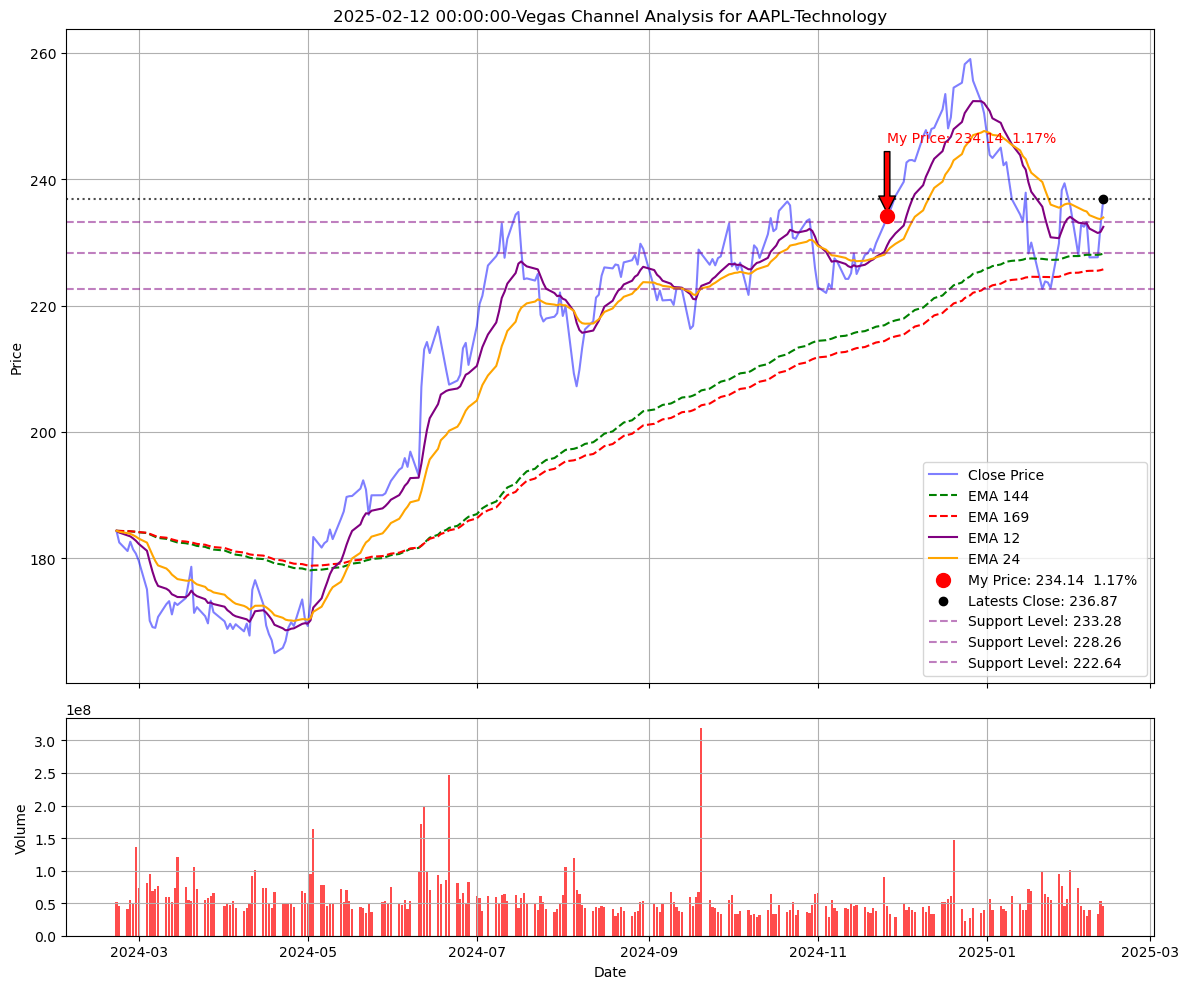

In [12]:
# Stock symbol and date range
symbol = 'AAPL'  # Apple
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-11-26', 234.14)
plt.close()

[*********************100%%**********************]  1 of 1 completed


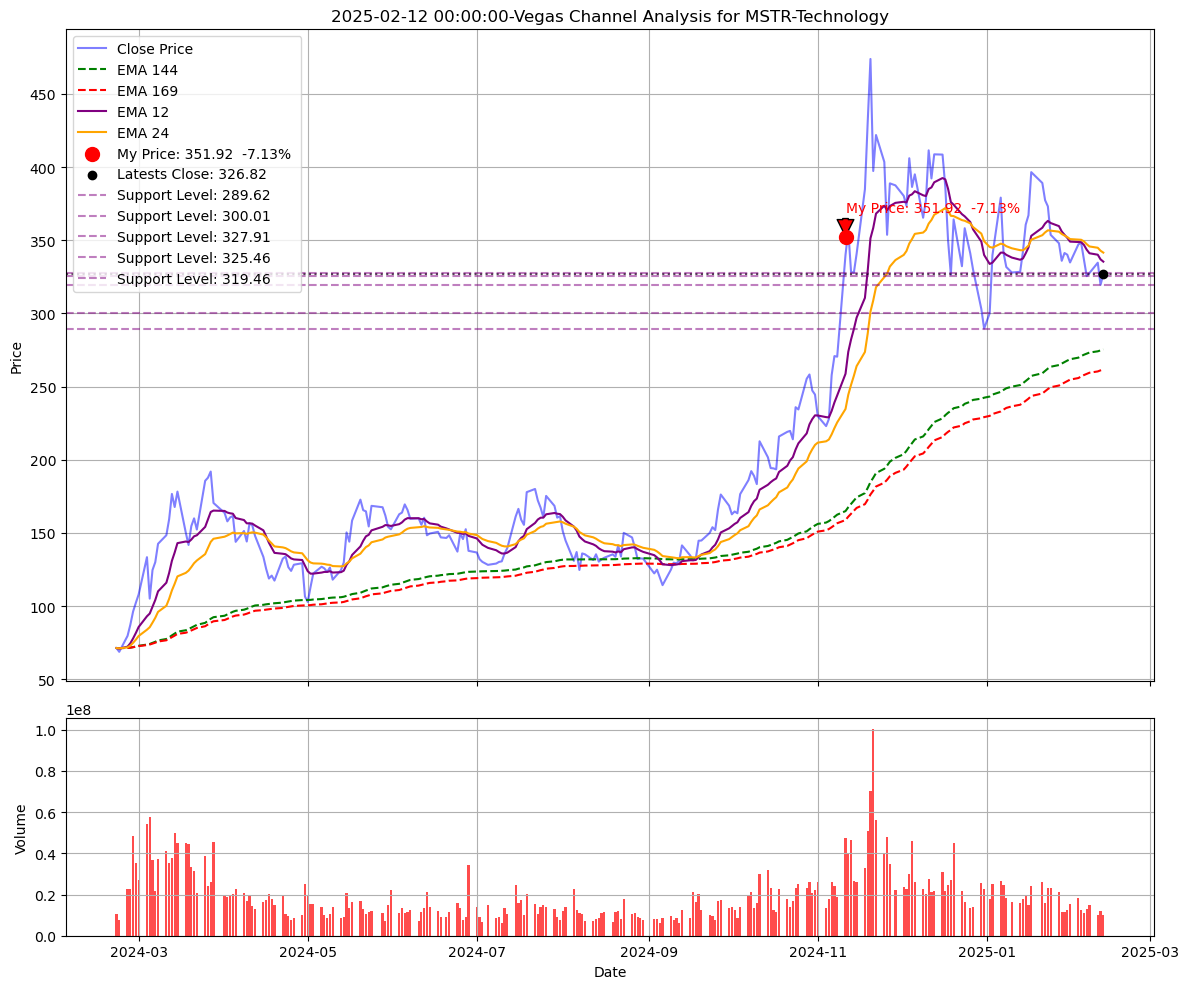

In [13]:
# Stock symbol and date range
symbol = 'MSTR'  # Microstrategy
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-11-11', 351.92)
plt.close()

[*********************100%%**********************]  1 of 1 completed


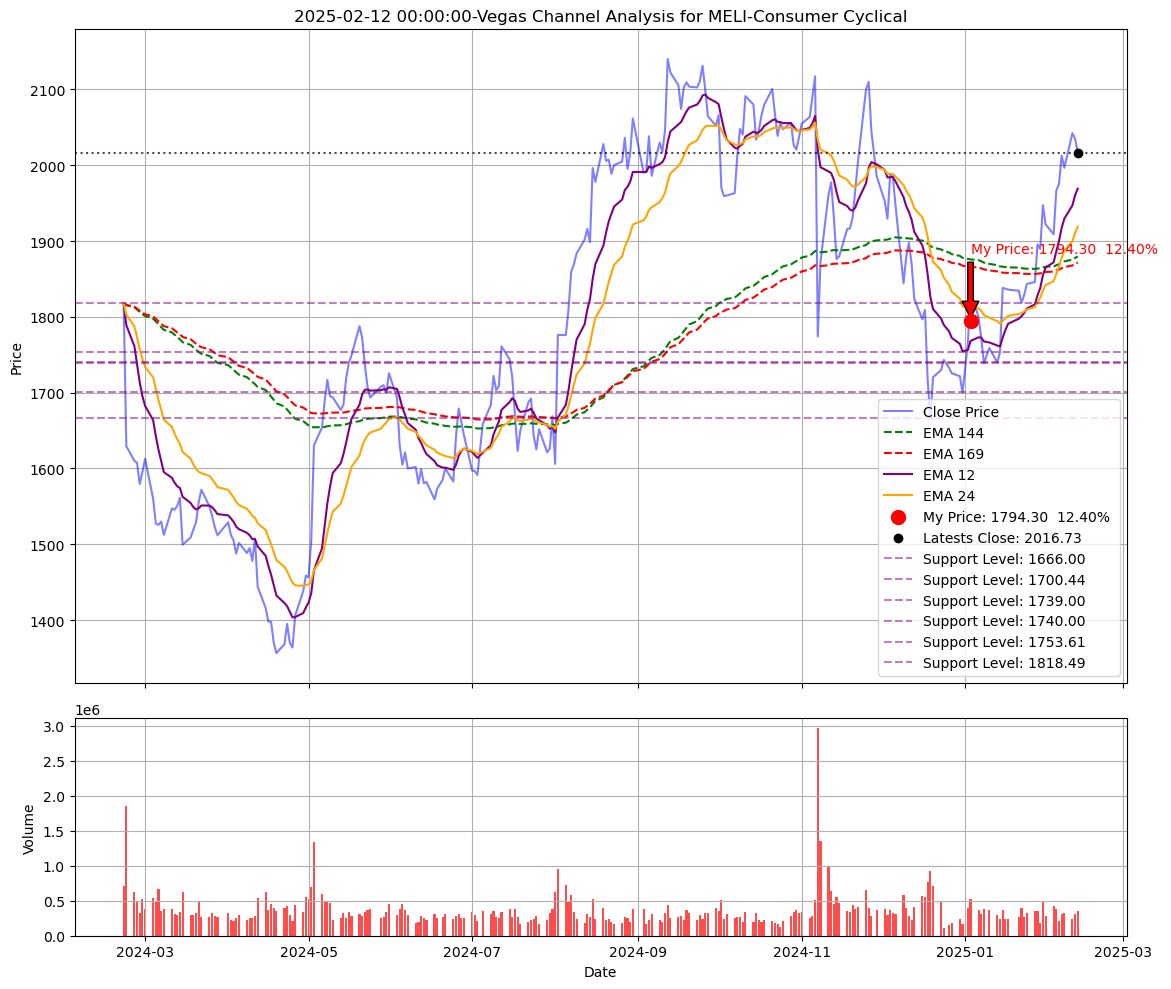

In [14]:
# Stock symbol and date range
symbol = 'MELI'  # MercadoLibre
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2025-01-03', 1794.3)
plt.close()

[*********************100%%**********************]  1 of 1 completed


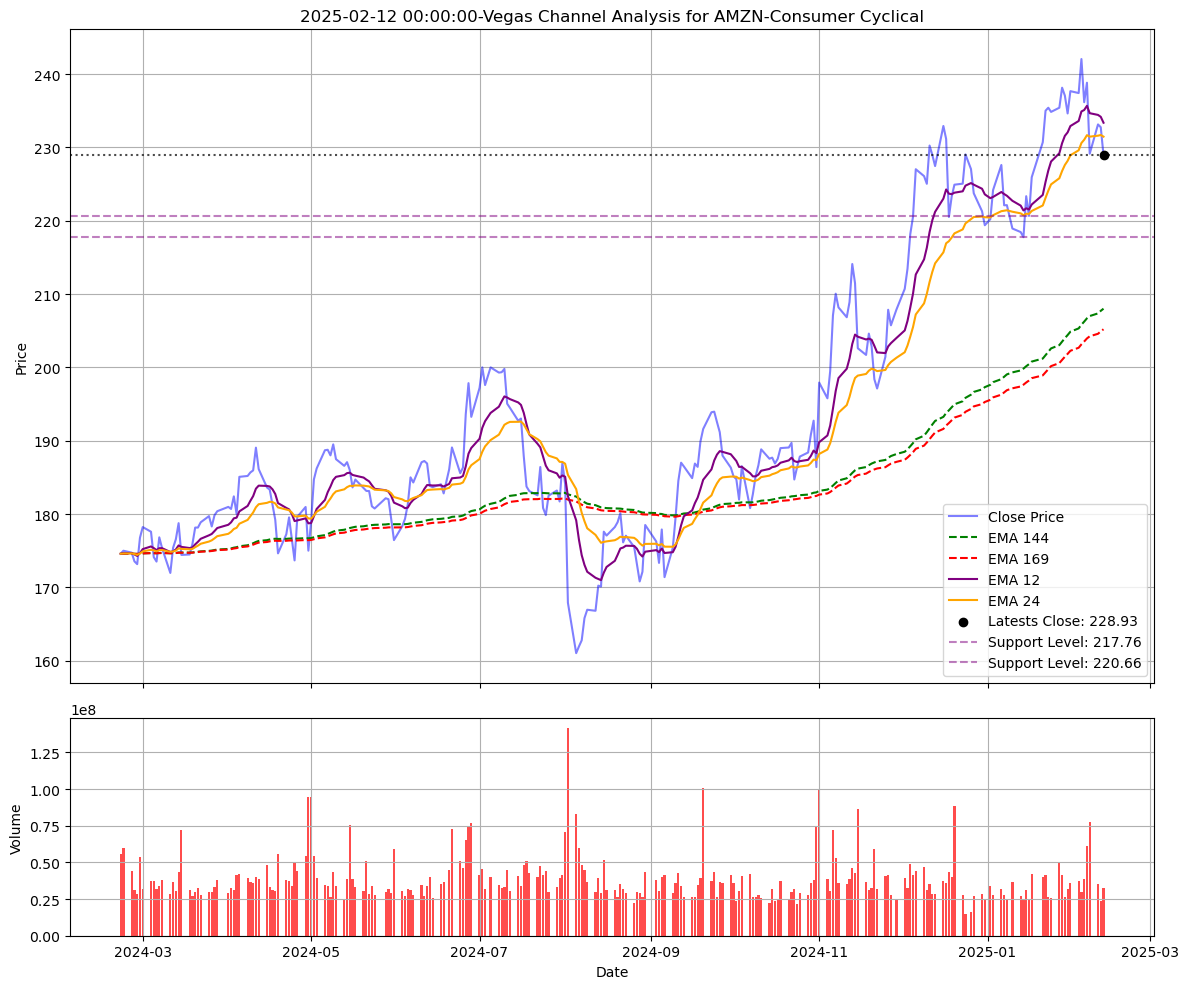

In [15]:
# Stock symbol and date range
symbol = 'AMZN'  # Example: Apple stock
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


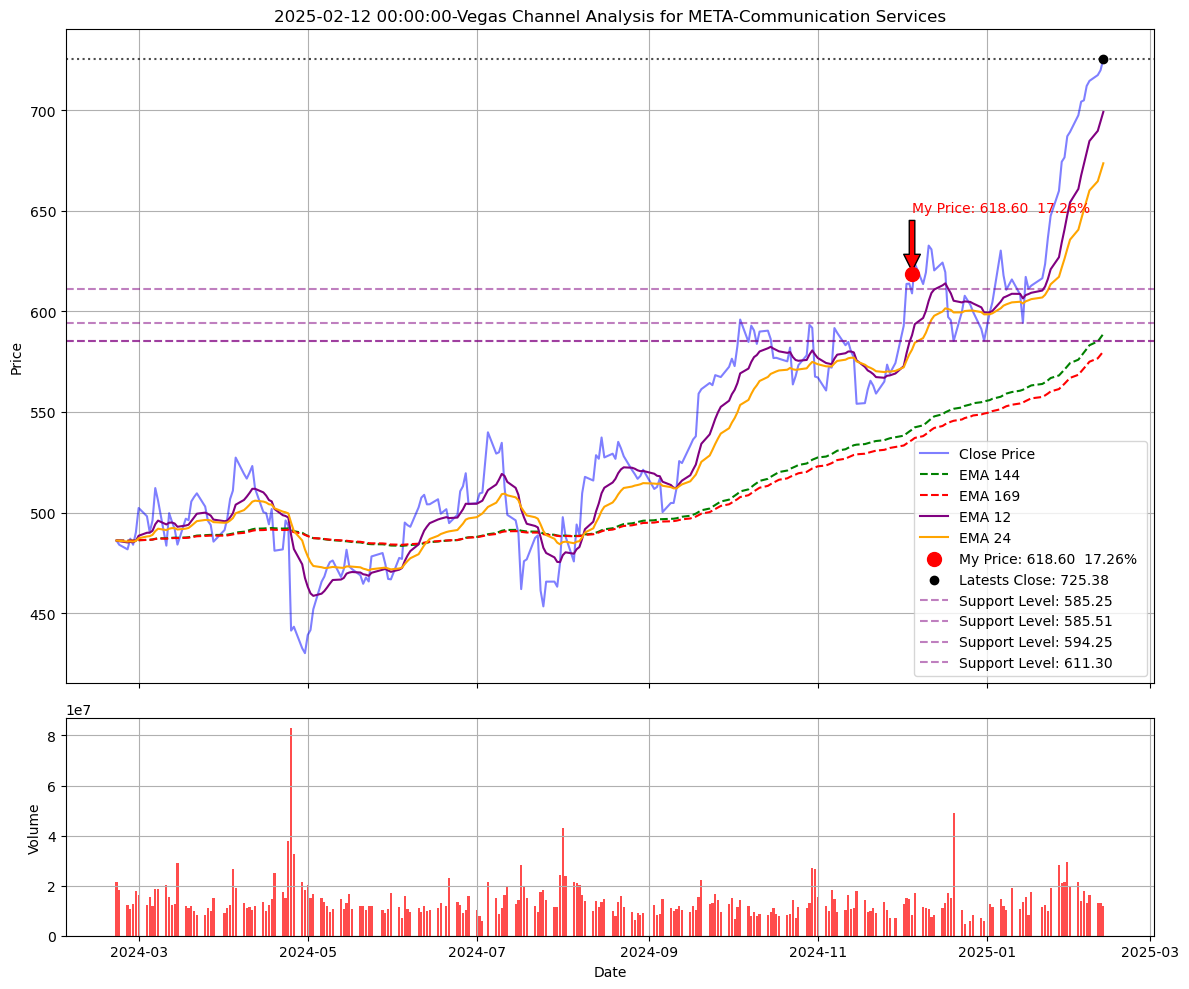

In [16]:
# Stock symbol and date range
symbol = 'META'  # FaceBook
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-12-05', 618.6)
plt.close()

[*********************100%%**********************]  1 of 1 completed


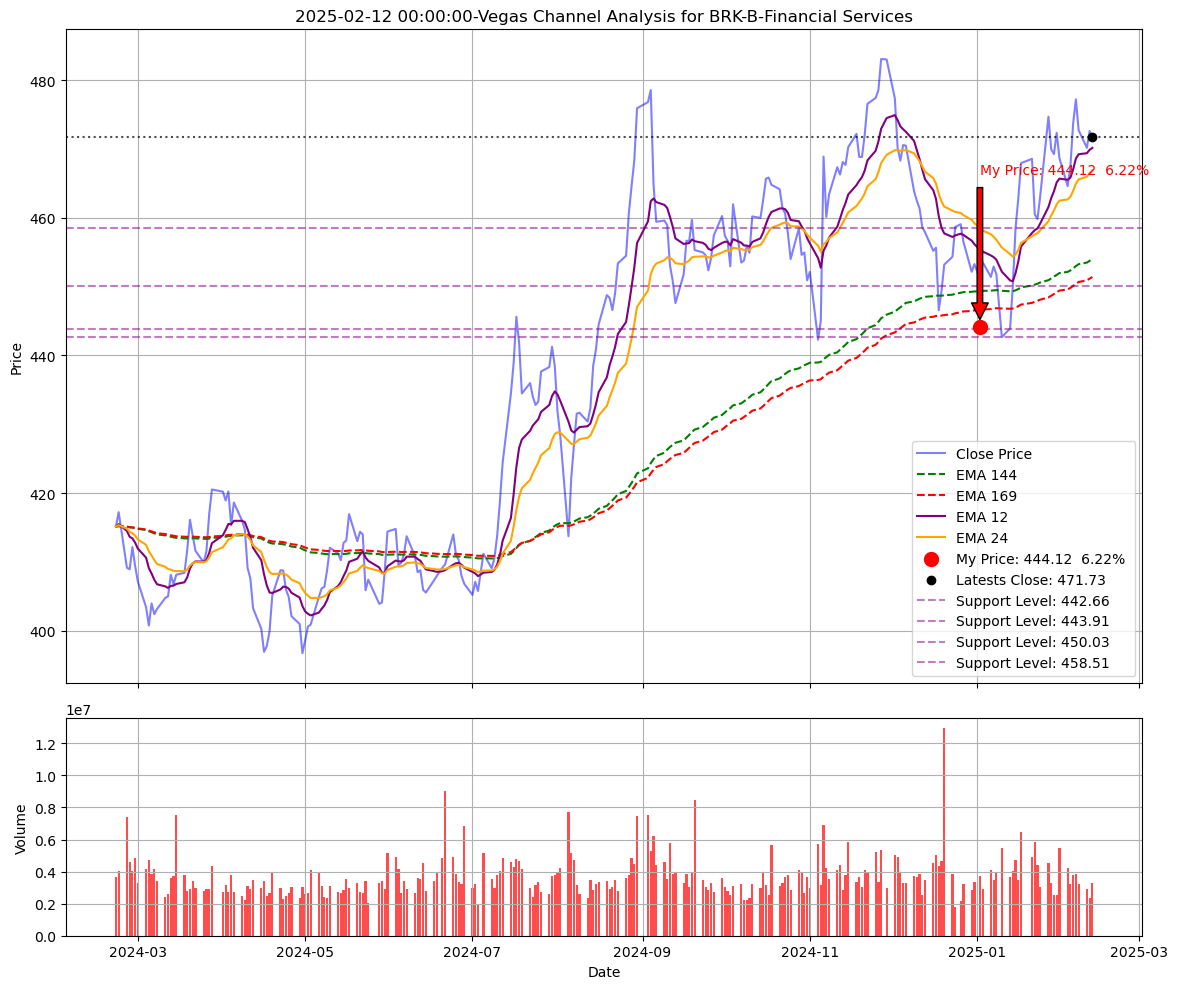

In [17]:
# Stock symbol and date range
symbol = 'BRK-B'  # Berkshire Hathaway Inc
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2025-01-02', 444.12)
plt.close()

[*********************100%%**********************]  1 of 1 completed


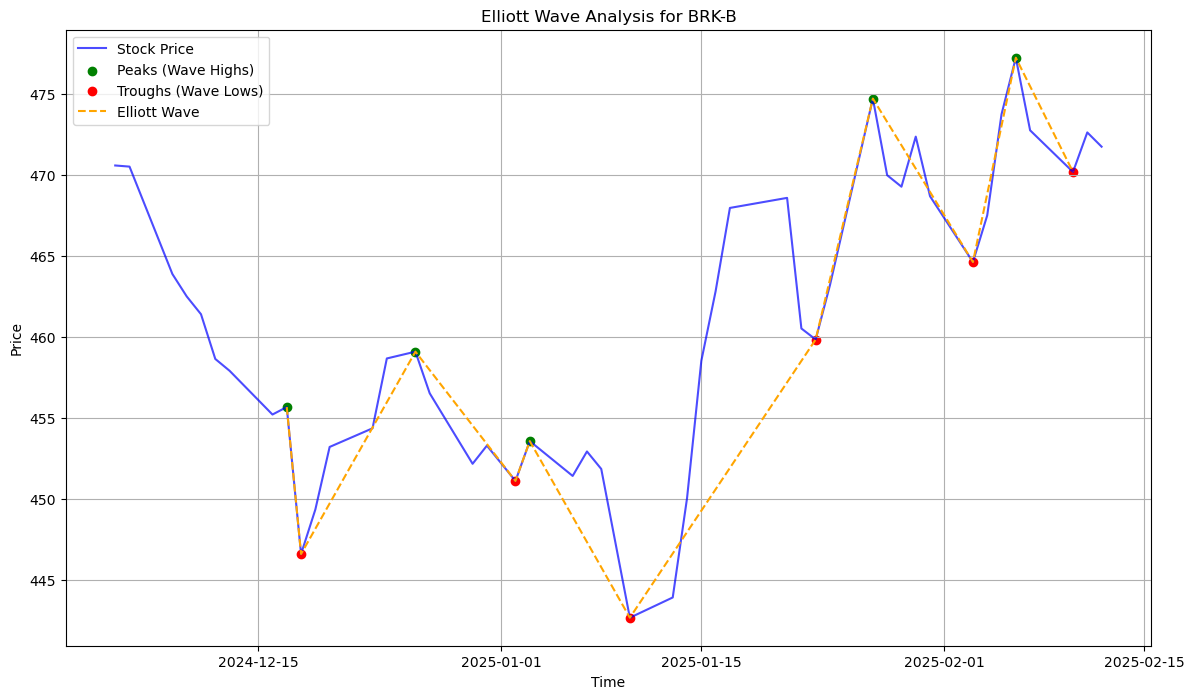

In [18]:
# Stock symbol and date range with Elliot Wave analysis
symbol = 'BRK-B'  # NVIDIA
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 10
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Step 1: Download the stock data
elliot_stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Step 2: Identify peaks and troughs
elliot_close_prices = elliot_stock_data['Close']
# test
#elliot_close_prices.plot()

distance = 5
peaks, troughs = identify_peaks_and_troughs(elliot_close_prices, distance=distance)

# Step 3: Plot the Elliott wave analysis
plot_elliott_wave(elliot_close_prices, peaks, troughs, title=f"Elliott Wave Analysis for {symbol}")
plt.close()

[*********************100%%**********************]  1 of 1 completed


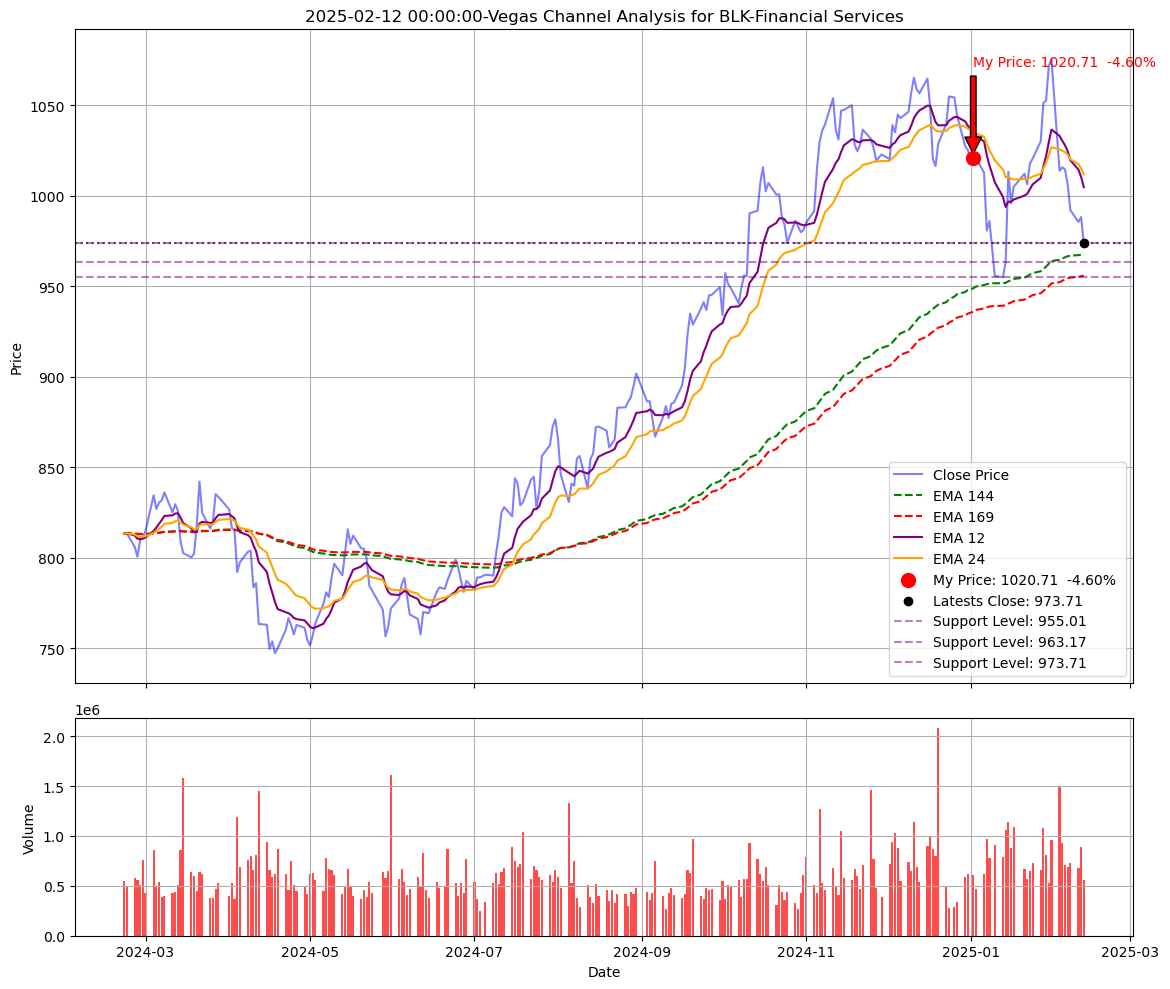

In [19]:
# Stock symbol and date range
symbol = 'BLK'  # Netflix
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2025-01-02', 1020.71)
plt.close()

[*********************100%%**********************]  1 of 1 completed


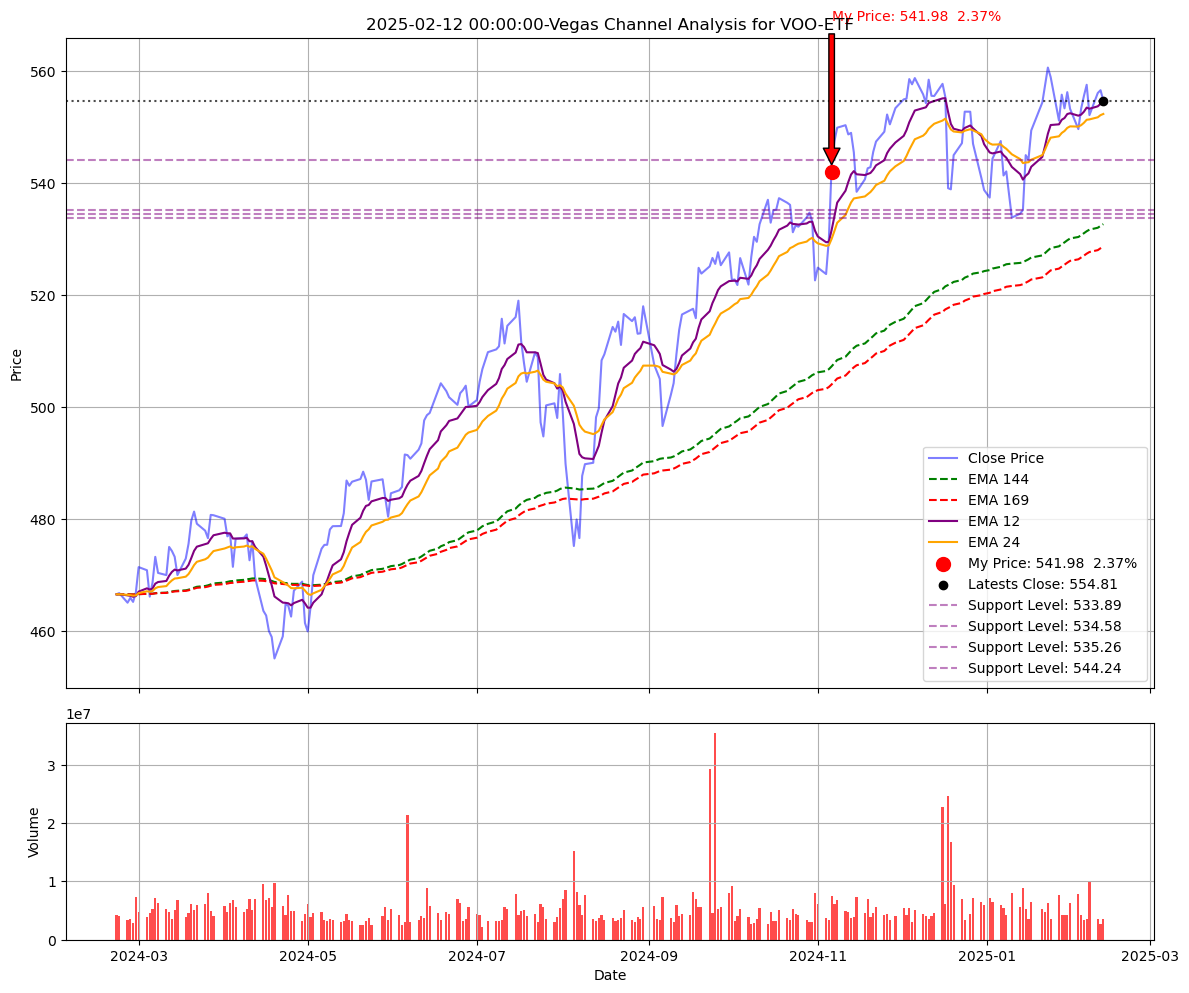

In [20]:
# Stock symbol and date range
symbol = 'VOO'  # VOO ETF
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-11-06', 541.98)
plt.close()

[*********************100%%**********************]  1 of 1 completed


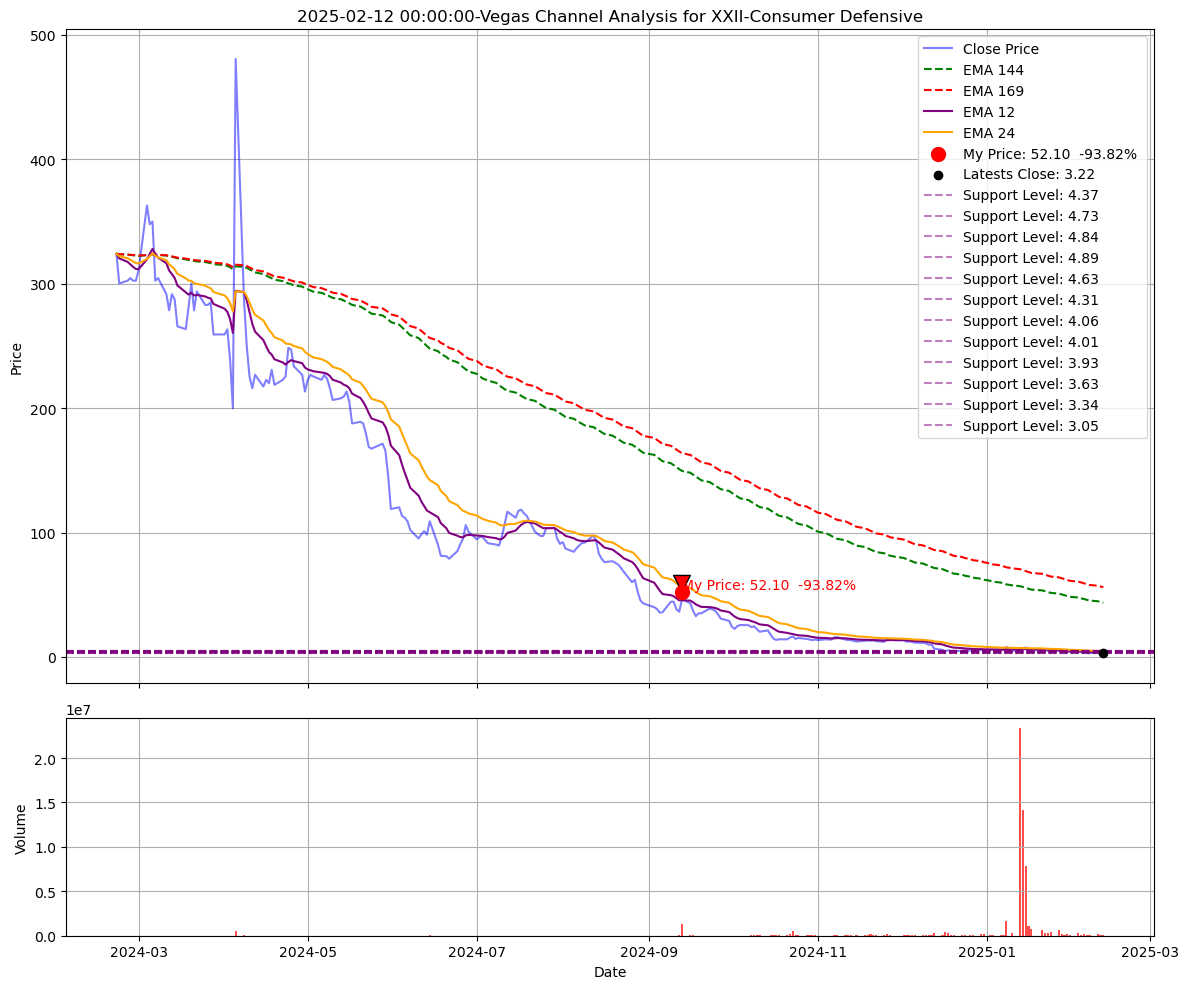

In [21]:
# Stock symbol and date range
symbol = 'XXII'  # Example: Apple stock
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-09-13', 52.1)
plt.close()

[*********************100%%**********************]  1 of 1 completed


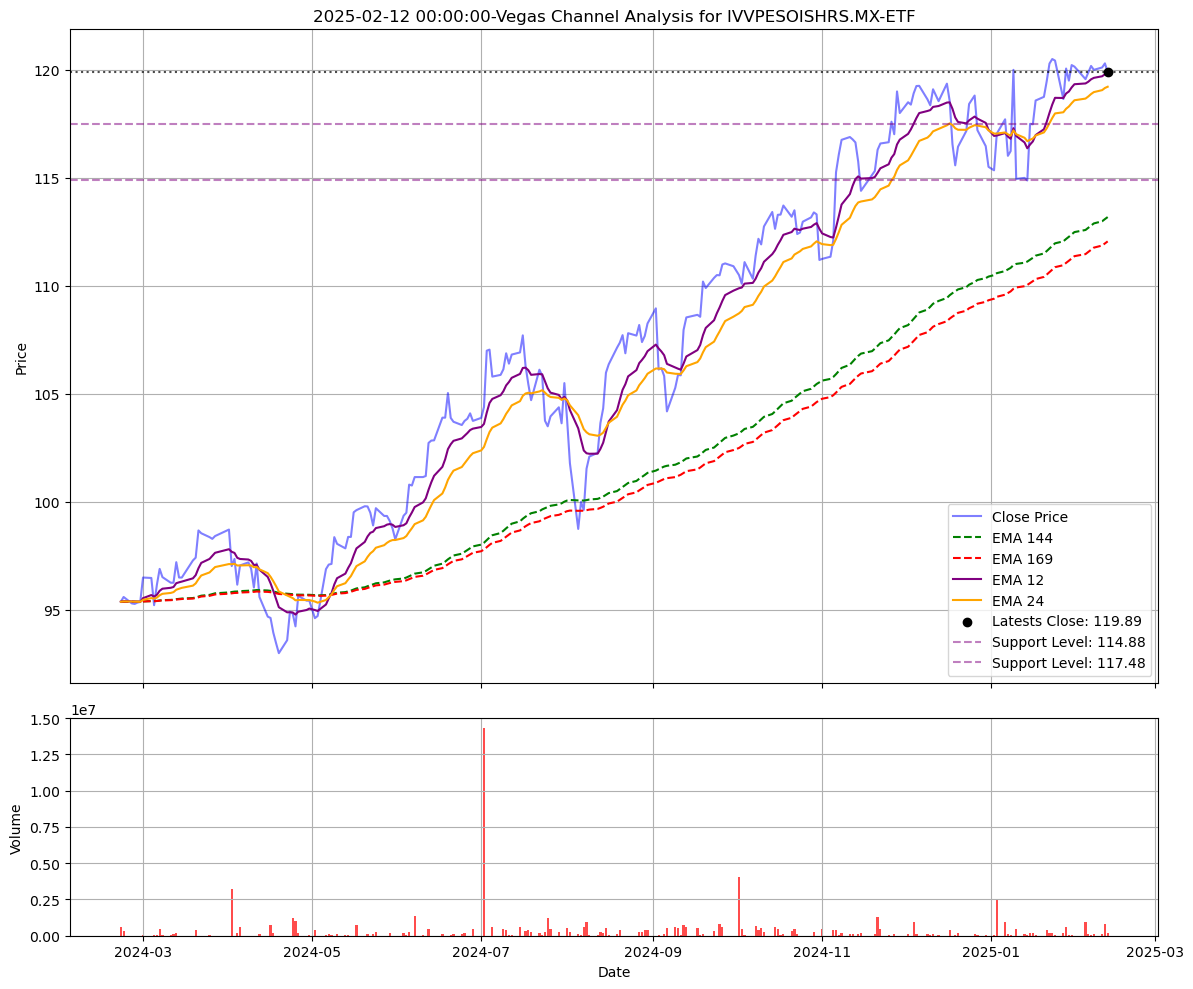

In [22]:
# Stock symbol and date range
symbol = 'IVVPESOISHRS.MX'  # IVVPESO ETF
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


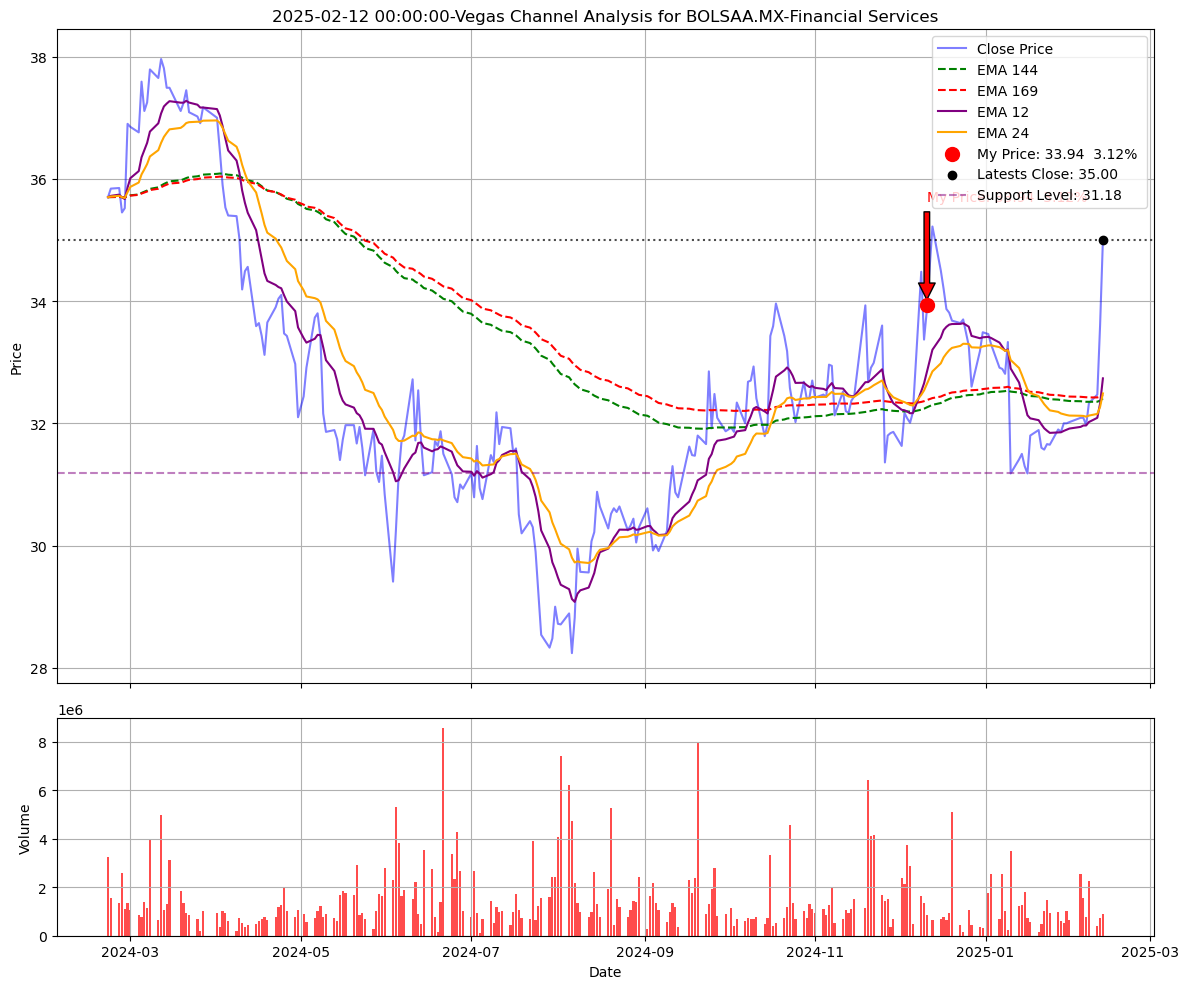

In [23]:
# Stock symbol and date range
symbol = 'BOLSAA.MX'  # Cemex
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-12-11', 33.94)
plt.close()

[*********************100%%**********************]  1 of 1 completed


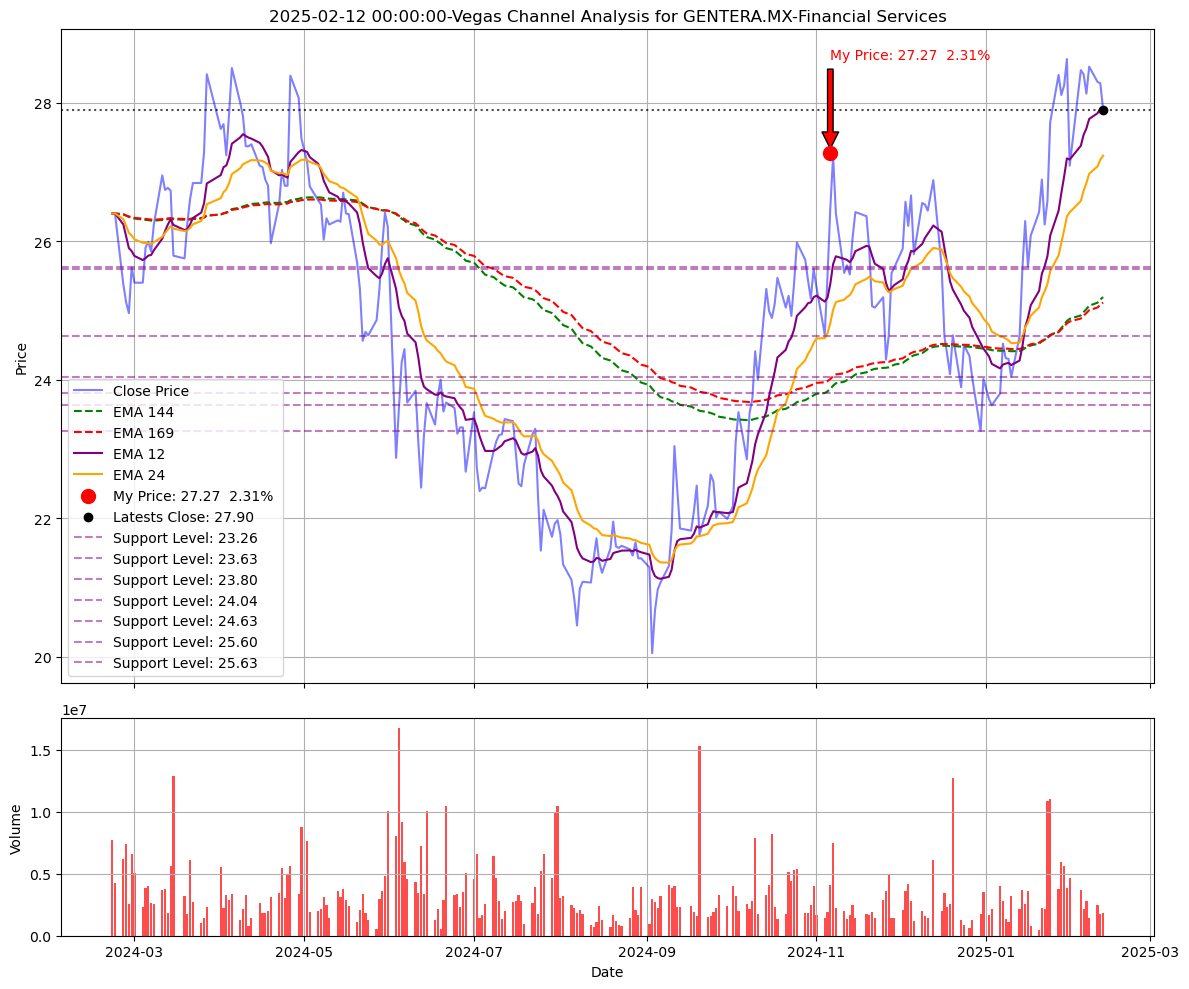

In [24]:
# Stock symbol and date range
symbol = 'GENTERA.MX'  # Gentera
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-11-06', 27.27)
plt.close()

[*********************100%%**********************]  1 of 1 completed


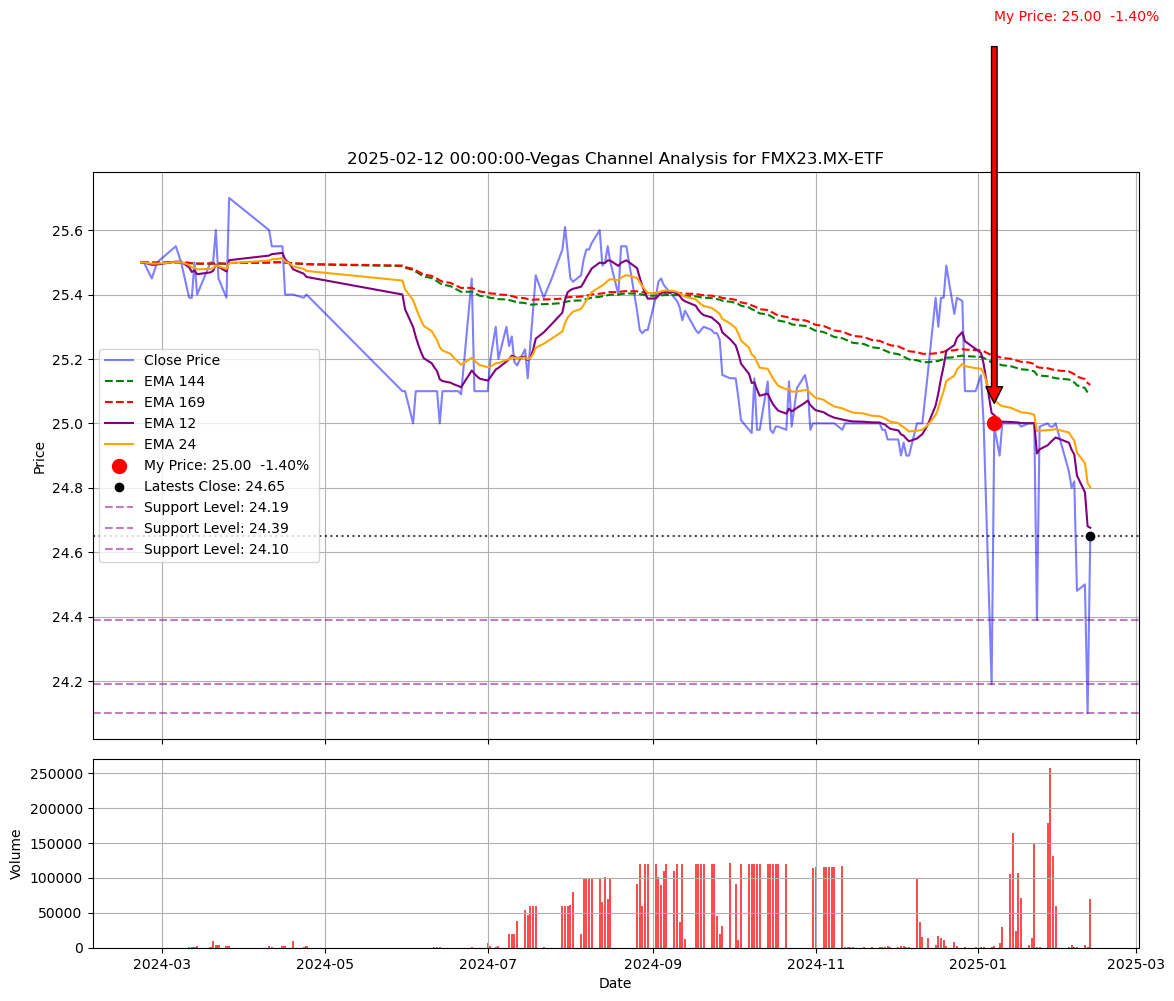

In [25]:
# Stock symbol and date range
symbol = 'FMX23.MX'  # Fibra Bienes Raices
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2025-01-07', 25.0)
plt.close()

[*********************100%%**********************]  1 of 1 completed


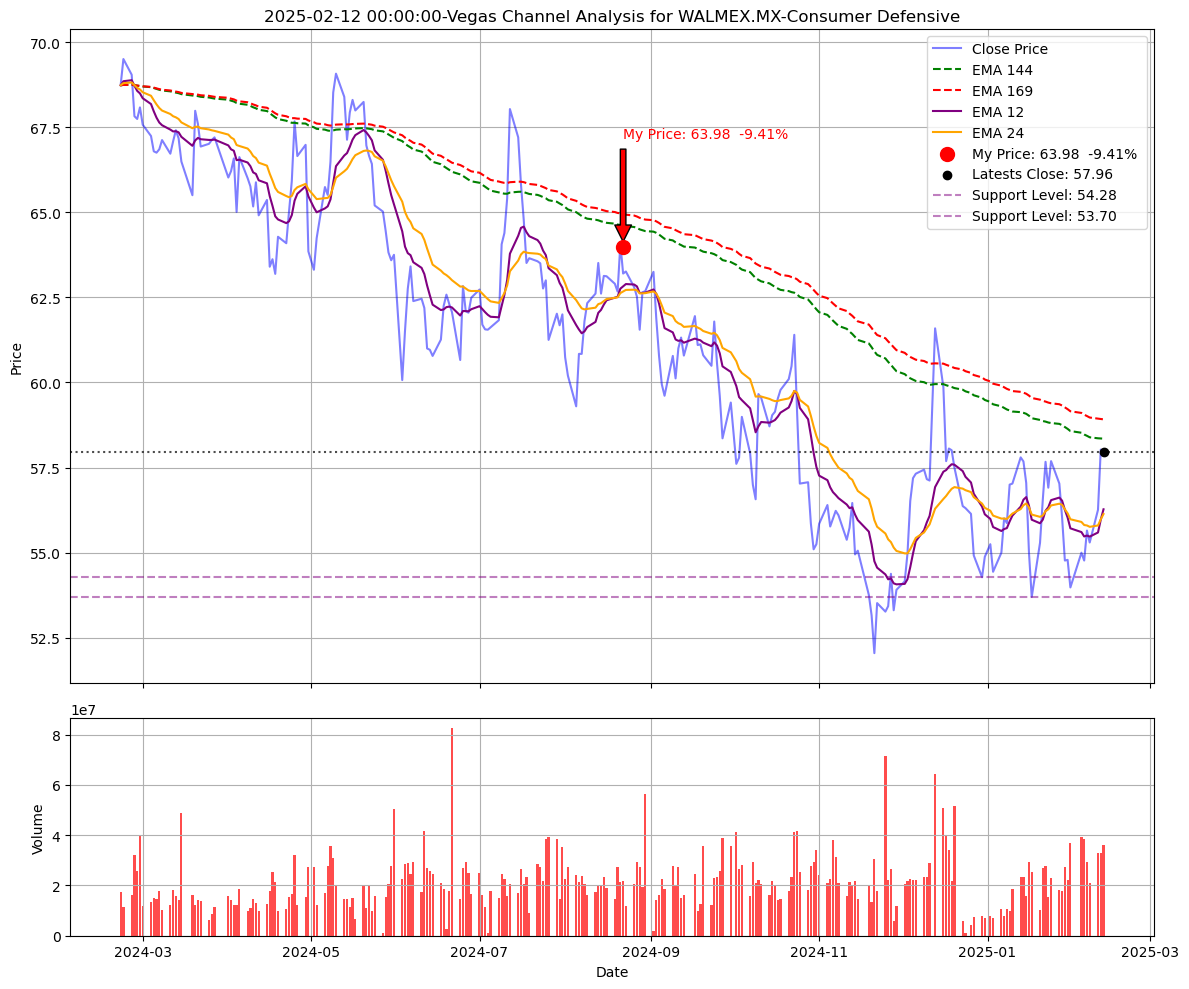

In [26]:
# Stock symbol and date range
symbol = 'WALMEX.MX'  # Walmart Mexico
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-08-22', 63.98)
plt.close()

[*********************100%%**********************]  1 of 1 completed


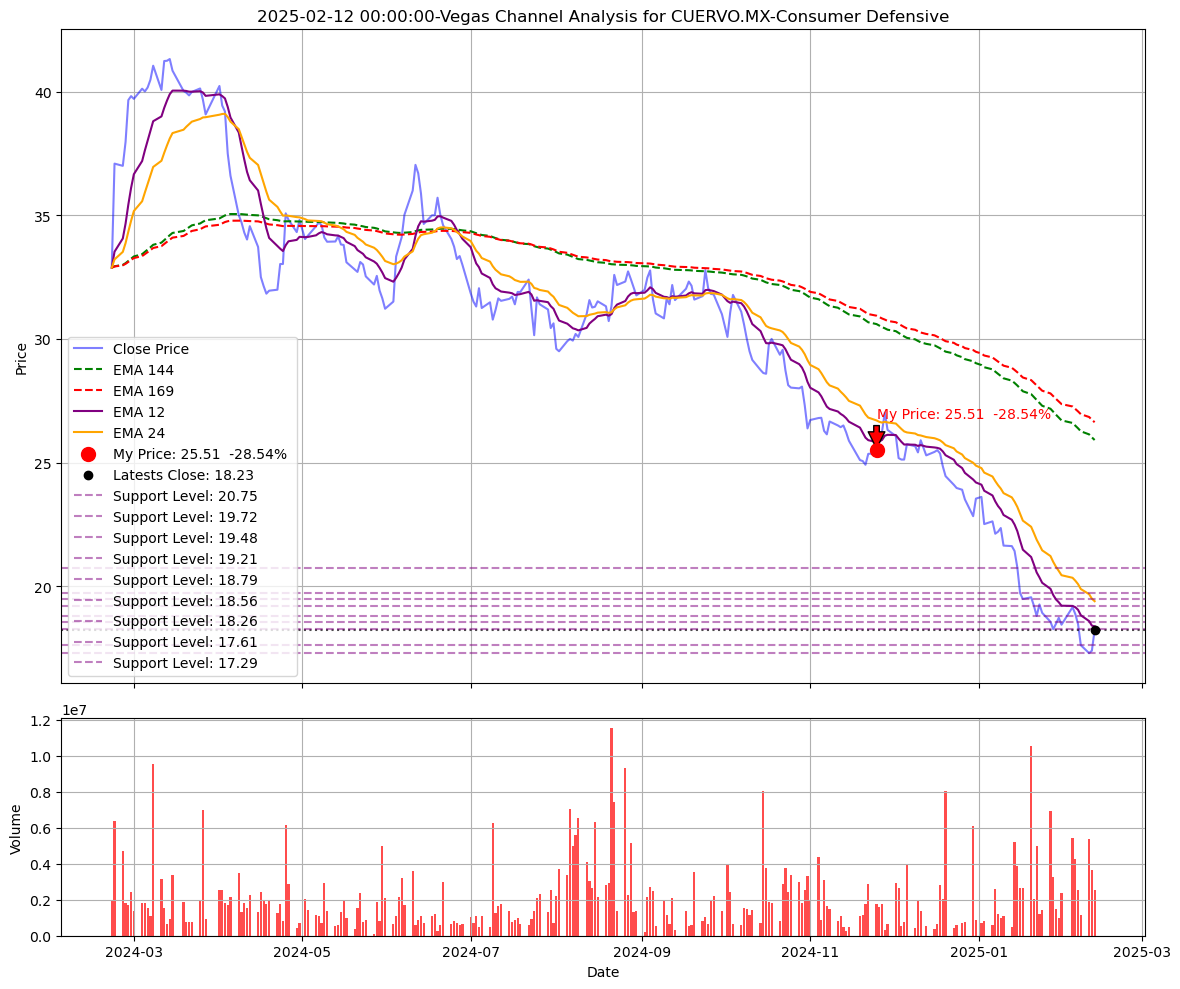

In [27]:
# Stock symbol and date range
symbol = 'CUERVO.MX'  # Cuervo
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-11-25', 25.51)
plt.close()

## PER
El radio PER (Price-to-Earnings Ratio, o relación precio-beneficio) es un indicador financiero que mide la relación entre el precio de una acción y las ganancias generadas por cada acción. Es ampliamente utilizado en el análisis fundamental para evaluar si una acción está sobrevalorada o infravalorada en comparación con sus pares o con el mercado en general.
### Interpretación del PER
#### PER Alto:
Indica que los inversores están dispuestos a pagar más por cada unidad de ganancia.
Esto puede sugerir expectativas de alto crecimiento futuro, pero también podría significar que la acción está sobrevalorada.
Es común en empresas de tecnología y sectores con alto crecimiento.
#### PER Bajo:
Indica que los inversores están pagando menos por cada unidad de ganancia.
Esto puede ser una señal de infravaloración, pero también podría reflejar problemas en la empresa o expectativas de bajo crecimiento.
#### PER Negativo:
Ocurre cuando la empresa tiene pérdidas (EPS negativo), lo que hace que el cálculo del PER sea irrelevante.

In [28]:
import sys
#import yfinance as yf

# List of stock tickers
tickers = [
    'NOC', 'LMT', 'GD', 'FDX', 'DE', 'LEN', 'HON', 'MCD', 'PEP', 'UL', 'JNJ', 
    'MC.PA', 'TGT', 'VZ', 'T', 'TMUS', 'LUMN', 'CMCSA', 'ZM', 'SNAP', 'OMC', 'PUBGY'
]

# Create a dictionary to store the P/E ratios
pe_ratios = {}

# Loop through each ticker to get the P/E ratio
for ticker in tickers:
    stock = yf.Ticker(ticker)
    pe_ratio = stock.info.get('trailingPE', None)  # Get the trailing P/E ratio
    pe_ratios[ticker] = pe_ratio

# Print the P/E ratios
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
for ticker, pe in sorted(pe_ratios.items(), key=lambda item: sys.maxsize):
#for ticker, pe in sorted(pe_ratios.items(), key=lambda item: item[1]):
    print(f"{ticker}: P/E Ratio = {pe}")


NOC: P/E Ratio = 16.051498
LMT: P/E Ratio = 19.494171
GD: P/E Ratio = 18.04692
FDX: P/E Ratio = 16.802044
DE: P/E Ratio = 20.656624
LEN: P/E Ratio = 8.647799
HON: P/E Ratio = 23.594254
MCD: P/E Ratio = 27.242529
PEP: P/E Ratio = 20.80288
UL: P/E Ratio = 23.611814
JNJ: P/E Ratio = 27.158895
MC.PA: P/E Ratio = 28.175299
TGT: P/E Ratio = 13.649682
VZ: P/E Ratio = 9.913044
T: P/E Ratio = 17.201342
TMUS: P/E Ratio = 27.469429
LUMN: P/E Ratio = None
CMCSA: P/E Ratio = 8.545895
ZM: P/E Ratio = 28.29236
SNAP: P/E Ratio = None
OMC: P/E Ratio = 10.983914
PUBGY: P/E Ratio = 16.147058


In [29]:
#import yfinance as yf
#import pandas as pd

# List of stock tickers
tickers = [
    'NOC', 'LMT', 'GD', 'FDX', 'DE', 'LEN', 'HON', 'MCD', 'PEP', 'UL', 'JNJ', 
    'MC.PA', 'TGT', 'VZ', 'T', 'TMUS', 'LUMN', 'CMCSA', 'ZM', 'SNAP', 'OMC', 'PUBGY'
]

# Initialize an empty list to store the data
data = []

# Loop through each ticker to get the historical P/E ratio and current stock value
for ticker in tickers:
    stock = yf.Ticker(ticker)
    
    # Fetch the current stock value (last closing price)
    current_price = stock.history(period="1d")['Close'].iloc[0]
    
    # Fetch the historical P/E ratio (for the latest data available)
    pe_ratio = stock.info.get('trailingPE', None)  # Trailing P/E ratio
    
    # gain
    if pe_ratio is None:
        pe_ratio = 1
    gain = current_price / pe_ratio
    
    # Add the stock data to the list
    data.append({'Ticker': ticker, 'P/E Ratio': pe_ratio, 'Current Stock Value': current_price, 'Gain p/stock': gain})

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Sort by 'Current Stock Value' in descending order
df_sorted = df.sort_values(by=['P/E Ratio','Gain p/stock'], ascending=False)
#for ticker, pe, price in df_sorted.items():
#    print(f"{ticker}: P/E Ratio = {pe}, price = {}")
print(df_sorted)
print(df_sorted.describe())
# Display the result
#try:
#  import ace_tools as tools
#except:
#  !pip install ace_tools
#  import ace_tools as tools

#tools.display_dataframe_to_user("Stock P/E Ratios and Current Values", df_sorted)


   Ticker  P/E Ratio  Current Stock Value  Gain p/stock
18     ZM  28.292360            85.160004      3.010000
11  MC.PA  28.175299           707.200012     25.100000
15   TMUS  27.469429           265.079987      9.650000
7     MCD  27.242529           310.019989     11.380000
10    JNJ  27.158895           157.250000      5.790000
9      UL  23.611814            55.959999      2.370000
6     HON  23.594254           205.270004      8.700000
8     PEP  20.802880           144.580002      6.949999
4      DE  20.656624           466.220001     22.570000
1     LMT  19.494171           434.720001     22.299999
2      GD  18.046920           246.160004     13.640001
14      T  17.201342            25.629999      1.490000
3     FDX  16.802044           263.119995     15.659999
21  PUBGY  16.147058            27.450001      1.700000
0     NOC  16.051498           455.059998     28.350002
12    TGT  13.649682           128.580002      9.420000
20    OMC  10.983914            81.940002      7

In [13]:
tengo error 1 Failed download:
['TSLA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TSLA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TSLA&crumb=Edge%3A+Too+Many+Requests

SyntaxError: invalid syntax (3860026351.py, line 1)

MC.PA estan dispuestos a pagar $26.24 por